# Factorisation de matrice et recommandations

Le notebook utilise la factorisation de matrice pour calculer des recommandations sur la base [movielens](https://grouplens.org/datasets/movielens/). On utilise le jeu de données [ml-latest-small.zip](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip).

In [1]:
%matplotlib inline

In [2]:
from papierstat.datasets import load_movielens_dataset
data = load_movielens_dataset(cache='movielens.zip')
list(sorted(data))

['links', 'movies', 'ratings', 'tags']

In [3]:
data['movies'].tail(n=2)

,movieId,title,genres
9123,164977,The Gay Desperado (1936),Comedy
9124,164979,"Women of '69, Unboxed",Documentary


In [4]:
import pandas
rate = data["ratings"]
rate["dt"] = pandas.to_datetime(rate["timestamp"], unit='s')
rate.tail(n=2)

,userId,movieId,rating,timestamp,dt
100002,671,6385,2.5,1070979663,2003-12-09 14:21:03
100003,671,6565,3.5,1074784724,2004-01-22 15:18:44


In [5]:
len(set(rate['userId'])), len(set(rate['movieId']))

(671, 9066)

In [6]:
rate.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


671 utilisateurs et 9066 films. C'est petit mais assez pour voir la factorisation et le temps que cela prend. Quelques idées sur les données.

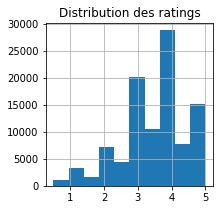

In [7]:
ax = rate['rating'].hist(bins=10, figsize=(3,3))
ax.set_title('Distribution des ratings');

Les gens préfèrent les ratings arrondis.

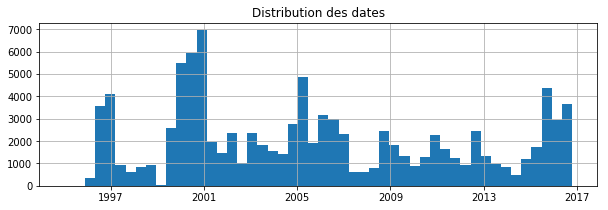

In [8]:
ax = rate['dt'].hist(bins=50, figsize=(10,3))
ax.set_title('Distribution des dates');

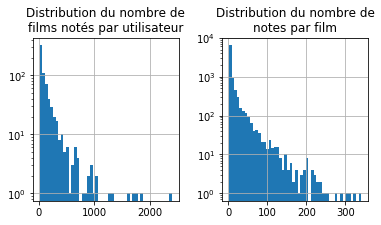

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(6,3))
gr = rate[["userId", "movieId"]].groupby('userId').count()
gr.hist('movieId', bins=50, figsize=(3,3), ax=ax[0])
ax[0].set_yscale('log')
ax[0].set_title('Distribution du nombre de\nfilms notés par utilisateur')
gr = rate[["userId", "movieId"]].groupby('movieId').count()
gr.hist('userId', bins=50, figsize=(3,3), ax=ax[1])
ax[1].set_yscale('log')
ax[1].set_title('Distribution du nombre de\nnotes par film');

Il y a quelques utilisateurs zélés et quelques films suscitant beaucoup d'intérêt. Ce ne sont pas des valeurs aberrantes mais il faudra songer à regarder ça de plus près un jour. Noter plus de 2000 films paraît suspect. Même si les votes s'étalent sur les 20 ans de collecte, cela fait un film tous les 3-4 jours. Il faut transformer les données sous la forme d'une matrice [sparse](https://docs.scipy.org/doc/scipy/reference/sparse.html).

In [10]:
from scipy.sparse import csr_matrix
import numpy


def conversion(rating, shape=None, movieId_col=None, userId_row=None):
    rating = rating[['userId', 'movieId', 'rating']].dropna()
    coefs = {}
    posix = {}
    movieId_col = movieId_col.copy() if movieId_col is not None else {}
    userId_row = userId_row.copy() if userId_row is not None else {}
    for ind, uid, mid, note in rating.itertuples():
        if uid not in userId_row:
            userId_row[uid] = len(userId_row)
        if mid not in movieId_col:
            movieId_col[mid] = len(movieId_col)
        row = userId_row[uid]
        col = movieId_col[mid]
        if row not in coefs:
            coefs[row] = []
            posix[row] = []
        coefs[row].append(note)
        posix[row].append(col)
        
    nbcoefs = sum(map(len, coefs.values()))
    indptr = numpy.zeros(len(coefs)+1)
    indices = numpy.zeros(nbcoefs)
    data = numpy.zeros(nbcoefs)    
    nb = 0
    for row in range(len(userId_row)):
        cs = coefs[row]
        ps = posix[row]
        indptr[row] = nb
        for i, (p, c) in enumerate(sorted(zip(ps, cs))):
            indices[nb] = p
            data[nb] = c
            nb += 1    
    
    indptr[-1] = nb
    if shape is None:
        shape = (len(userId_row), len(movieId_col))
    mat = csr_matrix((data, indices, indptr), shape=shape)
    if mat.max() != data.max():
        end = min(10, len(indptr))
        raise RuntimeError("La conversion s'est mal passée.\ndata={0}\nindices={1}\nindptr={2}".format(
                        data[:end], indices[:end], indptr[:end]))
    return mat, userId_row, movieId_col


petit = pandas.DataFrame(dict(userId=[0, 1, 1, 5, 5], movieId=[0, 1, 2, 4, 10], 
                              rating=[1, 2, 3, 4, 5]))

mat, userId_row, movieId_col = conversion(petit)
numpy.nan_to_num(mat.todense())

matrix([[1., 0., 0., 0., 0.],
        [0., 2., 3., 0., 0.],
        [0., 0., 0., 4., 5.]])

In [11]:
userId_row, '*', movieId_col

({0: 0, 1: 1, 5: 2}, '*', {0: 0, 1: 1, 2: 2, 4: 3, 10: 4})

In [12]:
mat, userId_row, movieId_col = conversion(rate)
numpy.nan_to_num(mat[:5,:5].todense())

matrix([[2.5, 3. , 3. , 2. , 4. ],
        [0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. ]])

On cale une factorisation de matrice.

In [13]:
from sklearn.decomposition import NMF
mf = NMF(n_components=20, shuffle=True, max_iter=400)
mf.fit(mat)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=400,
  n_components=20, random_state=None, shuffle=True, solver='cd',
  tol=0.0001, verbose=0)

In [14]:
mf.reconstruction_err_ 

897.9791684368183

In [15]:
wh = mf.transform(mat)
wh[:5,:5]

array([[0.        , 0.05039834, 0.        , 0.00358679, 0.        ],
       [0.        , 0.01736155, 1.91278876, 0.        , 0.        ],
       [0.20592908, 0.        , 0.29535495, 0.        , 0.        ],
       [0.        , 0.11052953, 0.        , 0.39806458, 0.        ],
       [0.71489676, 0.        , 0.20115088, 0.02163221, 0.        ]])

L'erreur ne dit pas grand chose sur la pertinence de la recommandation. Le plus simple est d'enlever des notes pour voir si on les retrouve.

In [16]:
from sklearn.model_selection import train_test_split
rate_train, rate_test = train_test_split(rate)

Il faut quand même s'assurer que la matrice à décomposer a les mêmes dimensions que la précédente avec toutes les données.

In [17]:
shape0 = mat.shape
mat_train, userId_row_train, movieId_col_train = conversion(rate, 
                    shape=shape0, userId_row=userId_row, movieId_col=movieId_col)

In [18]:
mf.fit(mat_train)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=400,
  n_components=20, random_state=None, shuffle=True, solver='cd',
  tol=0.0001, verbose=0)

In [19]:
mf.reconstruction_err_

898.1781492558509

On calcule l'erreur sur les bases d'apprentissage et de test.

In [20]:
def predict(mf, mat_train, test, userId_row, movieId_col):    
    W = mf.transform(mat_train)
    H = mf.components_
    wh = W @ H
    test = test[['userId', 'movieId', 'rating']]
    predictions = []
    for ind, uid, mid, note in test.itertuples(): 
        row = userId_row[uid]
        col = movieId_col[mid]
        try:
            pred = wh[row, col]        
        except Exception as e:
            raise Exception("Issue with uid={} mid={} row={} col={} shape={}".format(uid, mid, row, col, wh.shape))
        predictions.append((ind, pred))
    dfpred = pandas.DataFrame(data=predictions, columns=['index', 'prediction']).set_index('index')
    dfall = pandas.concat([test, dfpred], axis=1)
    return dfall

pred = predict(mf, mat_train, rate_test, userId_row_train, movieId_col_train)
pred.head()

,userId,movieId,rating,prediction
index,,,,
13240,85,356,4.0,4.934174
75789,527,1276,4.5,0.345162
42713,306,1513,4.0,2.439180
56562,407,3635,3.0,0.406101
63681,457,122882,0.5,0.903360


In [21]:
from sklearn.metrics import r2_score
r2_score(pred['rating'], pred['prediction'])

-4.659895568960519

Pas extraordinaire. Faisons varier *k*.

In [22]:
from time import perf_counter as clock
from sklearn.metrics import mean_squared_error
values = []

for k in [5, 10, 15, 20, 25, 30, 35]:
    mem = {}
    mf = NMF(n_components=k, shuffle=True, max_iter=400)
    cl = clock()
    mf.fit(mat_train)
    mem['train_time'] = clock() - cl
    pred = predict(mf, mat_train, rate_test, userId_row_train, movieId_col_train)
    mem['k'] = k
    mem['r2'] = r2_score(pred['rating'], pred['prediction'])
    mem['err_test'] = mean_squared_error(pred['rating'], pred['prediction'])
    mem['err_train'] = mf.reconstruction_err_
    values.append(mem)
    print(k, mem)    

5 {'train_time': 0.7479112074008754, 'k': 5, 'r2': -6.014138361502092, 'err_test': 7.929004708705666, 'err_train': 981.0205349504541}
10 {'train_time': 1.910340634477734, 'k': 10, 'r2': -5.388353487045178, 'err_test': 7.221597617417111, 'err_train': 943.8568240851894}
15 {'train_time': 2.2207374467998306, 'k': 15, 'r2': -4.96900640010828, 'err_test': 6.747554355716667, 'err_train': 918.0198374341521}
20 {'train_time': 5.637187125555101, 'k': 20, 'r2': -4.694288211755458, 'err_test': 6.437004193066304, 'err_train': 897.9357561628665}
25 {'train_time': 7.713239363839193, 'k': 25, 'r2': -4.420273628728207, 'err_test': 6.127249408216037, 'err_train': 878.84542031377}
30 {'train_time': 12.43995074364534, 'k': 30, 'r2': -4.195368644607753, 'err_test': 5.873009673241581, 'err_train': 862.2473126443812}
35 {'train_time': 15.610665020047463, 'k': 35, 'r2': -3.9997376232229183, 'err_test': 5.6518621552167065, 'err_train': 846.2449517351943}


In [23]:
df = pandas.DataFrame(values)
df

,err_test,err_train,k,r2,train_time
0,7.929005,981.020535,5,-6.014138,0.747911
1,7.221598,943.856824,10,-5.388353,1.910341
2,6.747554,918.019837,15,-4.969006,2.220737
3,6.437004,897.935756,20,-4.694288,5.637187
4,6.127249,878.845420,25,-4.420274,7.713239
5,5.873010,862.247313,30,-4.195369,12.439951
6,5.651862,846.244952,35,-3.999738,15.610665


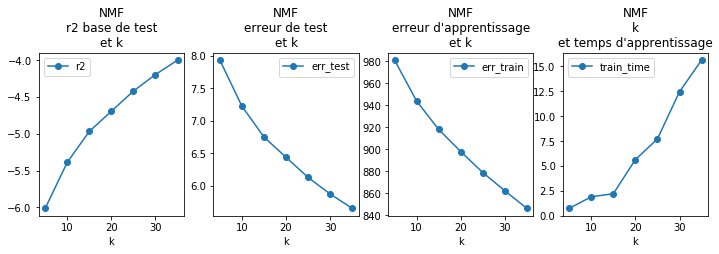

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
df.plot(x='k', y="r2", style='o-', ax=ax[0])
ax[0].set_title("NMF\nr2 base de test\net k")
df.plot(x='k', y="err_test", style='o-', ax=ax[1])
ax[1].set_title("NMF\nerreur de test\net k");
df.plot(x='k', y="err_train", style='o-', ax=ax[2])
ax[2].set_title("NMF\nerreur d'apprentissage\net k")
df.plot(y='train_time', x="k", style='o-', ax=ax[3])
ax[3].set_title("NMF\nk\net temps d'apprentissage");

Il faudrait explorer de plus grandes valeurs de *k*, il faudrait aussi faire de la cross-validation puis regarder si on peut corrélérer les plus autres erreurs à certains type d'utilisateurs ou de films, si on arrive à déterminer s'ils se distingue des autres par un faible ou fort taux de *ratings*, moyenne, plus ou moins proches des utilisateurs typiques (~*H*) ou des films typiques (~*W*). Bref, ce n'est pas fini.